In [1]:
%pip install pymc
%pip install pytensor


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pymc as pm
import numpy as np
import pytensor
import pytensor.tensor as pt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from scipy.stats import entropy, mode, variation

In [6]:
SEED = 9927
random_nr_generator = np.random.default_rng(SEED)

floatX = pytensor.config.floatX

In [7]:
X, y = load_digits(return_X_y=True)

X_used = X[np.isin(y, [0, 1, 2, 3, 4])]
y_used = y[np.isin(y, [0, 1, 2, 3, 4])]

X_novel = X[y == 5]
y_novel = y[y == 5]

X_train, X_test, y_train, y_test = train_test_split(X_used, y_used, test_size=0.2, random_state=SEED)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(floatX)
X_val = scaler.transform(X_val).astype(floatX)
X_test = scaler.transform(X_test).astype(floatX)
X_novel = scaler.transform(X_novel).astype(floatX)

In [8]:
# class_to_label = {0:0, 1:1, 2:2, 3:3, 5:4}
# y_train = np.array([class_to_label[label] for label in y_train])
# y_val = np.array([class_to_label[label] for label in y_val])
# y_test = np.array([class_to_label[label] for label in y_test])

In [9]:
y_train = y_train.astype(floatX)
y_val = y_val.astype(floatX)
y_test = y_test.astype(floatX)
y_novel = y_novel.astype(floatX)

In [10]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(X_novel.shape, y_novel.shape)

(576, 64) (576,)
(144, 64) (144,)
(181, 64) (181,)
(182, 64) (182,)


In [11]:
def construct_bayesian_neural_network(bnn_input, bnn_output, num_hidden_neurons, num_classes):
  # Initialize random weights between each layer
  init_1 = random_nr_generator.standard_normal(size=(bnn_input.shape[1], num_hidden_neurons)).astype(floatX)
  init_2 = random_nr_generator.standard_normal(size=(num_hidden_neurons, num_hidden_neurons)).astype(floatX)
  init_out = random_nr_generator.standard_normal(size=(num_hidden_neurons, num_classes)).astype(floatX)

  # Define coords parameter for training the model
  coords = {
      "hidden_layer_1": np.arange(num_hidden_neurons),
      "hidden_layer_2": np.arange(num_hidden_neurons),
      "output_layer": np.arange(num_classes),
      "train_cols": np.arange(bnn_input.shape[1]),
      # "obs_id": np.arange(bnn_input.shape[0]),
  }

  with pm.Model(coords=coords) as bayesian_neural_network:
    bnn_input = pm.Data("bnn_input", X_train, dims=("obs_id", "train_cols"))
    bnn_output = pm.Data("bnn_output", y_train, dims="obs_id")

    # Weights from input to first hidden layer
    weights_in_1 = pm.Normal("w_in_1", mu=0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1"))

    # Weights from first hidden layer to second hidden layer
    weights_1_2 = pm.Normal("w_1_2", mu=0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2"))

    # Weights from second hidden layer to output layer
    weights_2_out = pm.Normal("w_2_out", mu=0, sigma=1, initval=init_out, dims=("hidden_layer_2", "output_layer"))

    # Build bayesian neural network using tanh activation function
    act_1 = pm.math.tanh(pm.math.dot(bnn_input, weights_in_1))
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
    act_out = pm.math.softmax(pm.math.dot(act_2, weights_2_out), axis=-1)

    # Multiclass clasification -> Categorical likelihood
    out = pm.Categorical("out", p=act_out, observed=bnn_output, total_size=y_train.shape[0], dims="obs_id")
    act_out = pm.Deterministic("act_out", act_out)

  return bayesian_neural_network

In [12]:
num_hidden_neurons = 16
num_classes = len(np.unique(y_train))

In [13]:
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [14]:
bayesian_neural_network = construct_bayesian_neural_network(X_train, y_train, num_hidden_neurons, num_classes)

In [15]:
with bayesian_neural_network:
  approx = pm.fit(n=3000)

Output()

Finished [100%]: Average Loss = 1,559.6


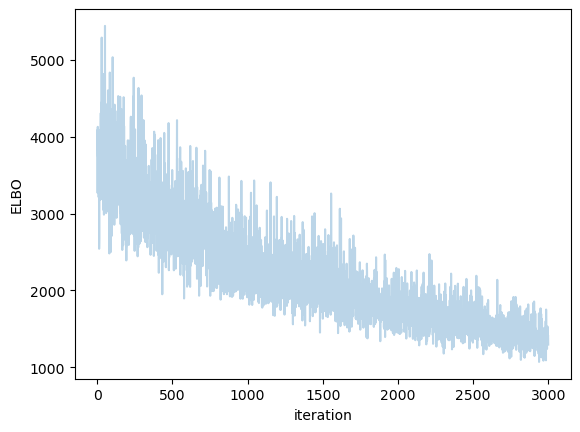

In [16]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration")
plt.show()

In [17]:
trace = approx.sample(draws=5000)
with bayesian_neural_network:
  pm.set_data({"bnn_input": X_val}, coords={
    "hidden_layer_1": np.arange(num_hidden_neurons),
    "hidden_layer_2": np.arange(num_hidden_neurons),
    "output_layer": np.arange(num_classes),
    "train_cols": np.arange(X_val.shape[1]),
    # "obs_id": np.arange(X_val.shape[0]),
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out"])
  trace.extend(ppc)

Sampling: [out]


Output()

In [18]:
for item in ppc.posterior_predictive['out']:
    preds = []
    print(item.shape)
    for i in range(item.shape[1]):
        classes = []
        for j in range(item.shape[0]):
            #print(item[j][i])
            classes.append(item[j][i])

        #print(classes)
        #print(np.argmax(np.bincount(classes)), y_test[i])
        preds.append(np.argmax(np.bincount(classes)).astype(floatX))

(5000, 144)


In [19]:
trace = approx.sample(draws=5000)
with bayesian_neural_network:
  pm.set_data({"bnn_input": X_test}, coords={
    "hidden_layer_1": np.arange(num_hidden_neurons),
    "hidden_layer_2": np.arange(num_hidden_neurons),
    "output_layer": np.arange(num_classes),
    "train_cols": np.arange(X_test.shape[1]),
    # "obs_id": np.arange(X_test.shape[0]),
  })
  ppc = pm.sample_posterior_predictive(trace, var_names=["out", "act_out"])
  trace.extend(ppc)

Sampling: [out]


Output()

In [20]:
print(ppc.posterior_predictive['out'])
print(ppc.posterior_predictive['out'].shape)

preds = []
for item in ppc.posterior_predictive['out']:
    for i in range(item.shape[1]):
        classes = []
        for j in range(item.shape[0]):
            classes.append(item[j][i])

        preds.append(np.argmax(np.bincount(classes)).astype(floatX))

<xarray.DataArray 'out' (chain: 1, draw: 5000, obs_id: 181)>
array([[[2, 0, 4, ..., 3, 3, 3],
        [2, 0, 4, ..., 3, 1, 1],
        [4, 4, 0, ..., 3, 1, 0],
        ...,
        [2, 4, 1, ..., 3, 3, 0],
        [2, 0, 4, ..., 3, 3, 3],
        [2, 0, 2, ..., 2, 3, 3]]], dtype=int64)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999
  * obs_id   (obs_id) int32 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179 180
(1, 5000, 181)


In [21]:
# Predict on test set
for item in ppc.posterior_predictive['out']:
    preds = []
    for i in range(item.shape[1]):
        classes = []
        for j in range(item.shape[0]):
            classes.append(item[j][i])

        preds.append(np.argmax(np.bincount(classes)).astype(floatX))

# Calculate accuracy
acc = np.mean(preds == y_test)
print(f"Accuracy: {acc}")

Accuracy: 0.8729281767955801


In [22]:
# Extract probabilities for each prediction from posterior predictive samples
softmax_probs = []

# Iterate over posterior predictive samples
for item in ppc.posterior_predictive['out']:
    probs = []
    for i in range(item.shape[1]):  # Iterate over each example
        # Count occurrences of each class across posterior samples
        class_counts = np.bincount(item[:, i], minlength=5)
        # Normalize to get probabilities
        class_probs = class_counts / np.sum(class_counts)
        probs.append(class_probs)
    softmax_probs.append(probs)

# Convert to a NumPy array for easier handling
softmax_probs = np.array(softmax_probs)  # Shape: (num_samples, num_examples, num_classes)

# View probabilities for the first few examples
for i in range(10):  # First 5 examples
    print(f"Example {i+1} probabilities: {np.mean(softmax_probs[:, i, :], axis=0)}")

print(preds[:10])

# standard deviation for each class 

print(ppc.posterior_predictive['act_out'].shape)


Example 1 probabilities: [0.0546 0.0336 0.7542 0.1128 0.0448]
Example 2 probabilities: [0.5934 0.036  0.0224 0.0218 0.3264]
Example 3 probabilities: [0.125  0.1624 0.0234 0.0082 0.681 ]
Example 4 probabilities: [0.0048 0.6478 0.0644 0.1134 0.1696]
Example 5 probabilities: [0.0112 0.6046 0.1256 0.2148 0.0438]
Example 6 probabilities: [0.062  0.0466 0.6394 0.232  0.02  ]
Example 7 probabilities: [0.0962 0.1564 0.0234 0.012  0.712 ]
Example 8 probabilities: [0.0458 0.0472 0.3618 0.5428 0.0024]
Example 9 probabilities: [0.1166 0.3088 0.3652 0.1782 0.0312]
Example 10 probabilities: [0.0866 0.6076 0.0134 0.1776 0.1148]
[2.0, 0.0, 4.0, 1.0, 1.0, 2.0, 4.0, 3.0, 2.0, 1.0]
(1, 5000, 181, 5)


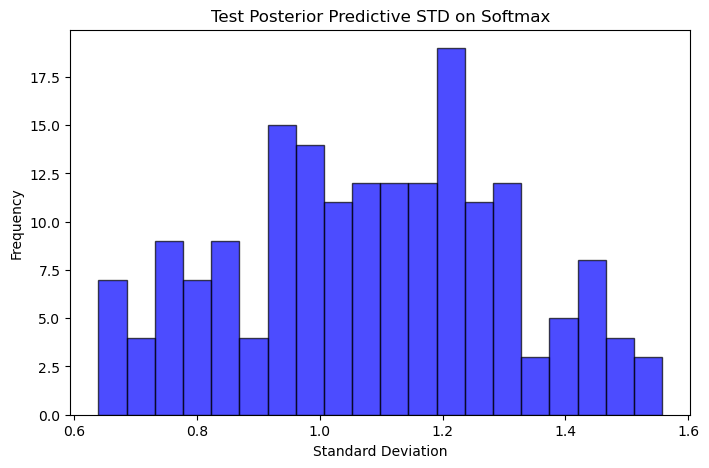

array([1.02658228, 1.1144814 , 1.08327761, 1.13534705, 1.19493954,
       1.14989618, 1.04963462, 1.1147163 , 1.44523288, 1.23037588,
       1.06624931, 0.70386749, 1.00743609, 1.10794015, 0.94088798,
       1.42122033, 1.2685338 , 0.67276079, 1.00465176, 1.29948887,
       1.39446077, 1.2241482 , 1.22097217, 1.24215527, 1.07702364,
       1.13916406, 0.8039022 , 1.19454665, 0.63919754, 1.15852558,
       1.45380451, 1.11968428, 1.21626994, 0.79447872, 1.42211467,
       0.84158125, 1.2857098 , 1.19928473, 0.81700337, 0.81200871,
       1.24216374, 0.98877946, 1.2068083 , 1.29591454, 1.14468203,
       1.02976408, 0.85330182, 1.39294723, 1.29420622, 1.12082232,
       1.01752504, 0.88802517, 1.20278802, 1.16152983, 0.78403199,
       0.80272097, 1.07377547, 1.18583806, 0.99594697, 1.22350208,
       0.91529775, 0.71186098, 0.9311824 , 1.16763745, 1.23751037,
       0.81366233, 1.24978192, 0.760772  , 1.47611635, 0.96675034,
       1.16821429, 1.47382411, 0.72629677, 1.25906511, 0.87223

In [23]:
def uncert_2(y_sm_test,verb=0,what='Test'):
    # Placeholder for total uncertainty (sum of STDs for each class) for each test point
    uncert_list = []
    
    # Loop through each test point
    for i in range(y_sm_test.shape[2]):
        # Extract softmax draws for the i-th test point
        y_sm_one = y_sm_test[0, :, i, :]  # Shape: (n_draws, n_classes)
    
        # Compute STD for each class along the draws
        std_per_class = np.std(y_sm_one, axis=0)  # Shape: (n_classes,)
    
        # Sum up the STDs for all classes
        total_uncertainty = np.sum(std_per_class)
    
        # Store the total uncertainty
        uncert_list.append(total_uncertainty)
    
    # Convert the list to a numpy array for easier processing
    uncert_array = np.array(uncert_list)

    if verb==1:
        # Plot histogram of STD
        plt.figure(figsize=(8, 5))
        plt.hist(uncert_array, bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title("{} Posterior Predictive STD on Softmax".format(what))
        plt.xlabel("Standard Deviation")
        plt.ylabel("Frequency")
        plt.show()
    return uncert_array

uncert_2(ppc.posterior_predictive['act_out'],verb=1,what='Test')



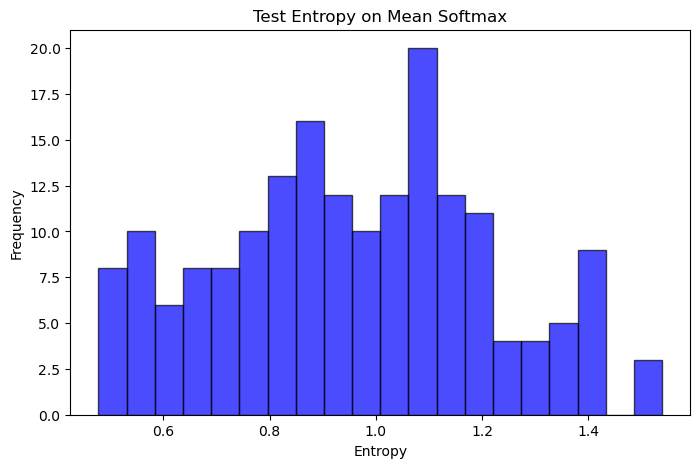

array([0.85727282, 0.95223443, 0.95229711, 1.02862941, 1.08005193,
       1.01479837, 0.89564791, 0.99210457, 1.4021508 , 1.12617749,
       0.91102206, 0.50758402, 0.86721182, 1.01441326, 0.78012978,
       1.36435676, 1.16418222, 0.51123535, 0.85325735, 1.18413977,
       1.30842956, 1.10228571, 1.10644907, 1.12791732, 0.93069596,
       0.99717   , 0.63784348, 1.04030379, 0.47773497, 1.10747801,
       1.40981411, 0.97866571, 1.08340636, 0.62471357, 1.35554752,
       0.68323442, 1.20420712, 1.08371832, 0.63445129, 0.64433235,
       1.09468181, 0.85006317, 1.08496947, 1.18685541, 1.08005097,
       0.89808782, 0.69720343, 1.30534891, 1.2069262 , 0.99980453,
       0.86132937, 0.71345638, 1.07067   , 1.01887538, 0.61895207,
       0.61393776, 0.96079644, 1.08628677, 0.85512373, 1.09332745,
       0.79977959, 0.54632946, 0.76404273, 1.02760509, 1.11144538,
       0.64102458, 1.14990974, 0.57506914, 1.42691309, 0.79721528,
       1.02960831, 1.39194345, 0.55283857, 1.13183008, 0.68553

In [24]:
def entropy(probs,eps=1e-10):
    entrop=0
    
    for i in range(probs.shape[0]):
        entrop=entrop+probs[i]*np.log(probs[i]+eps)
    entrop=-entrop
    return entrop
    
#Metoda 3 ---- Entropie din medie
num_classes=5
def uncert_3(y_sm_test,verb=0,what='Test',eps=1e-10):
    uncert_list = []
    
    # Loop through each test point
    for i in range(y_sm_test.shape[2]):
        # Extract softmax draws for the i-th test point
        y_sm_one = y_sm_test[0, :, i, :]  # Shape: (n_draws, n_classes)

        mean_probs = np.mean(y_sm_one, axis=0)  # Shape: (n_classes,)
        entropy_one=entropy(mean_probs,eps)  
        # Store the total uncertainty
        uncert_list.append(entropy_one)
    
    # Convert the list to a numpy array for easier processing
    uncert_array = np.array(uncert_list)
    
    if verb==1:
        plt.figure(figsize=(8, 5))
        plt.hist(uncert_array, bins=20, color='blue', alpha=0.7, edgecolor='black')
        plt.title("{} Entropy on Mean Softmax".format(what))
        plt.xlabel("Entropy")
        plt.ylabel("Frequency")
        plt.show()
    return uncert_array

uncert_3(ppc.posterior_predictive['act_out'],verb=1,what='Test')

In [25]:
# # Test for the novel class

# trace = approx.sample(draws=5000)
# with bayesian_neural_network:
#   pm.set_data({"bnn_input": X_novel}, coords={
#     "hidden_layer_1": np.arange(num_hidden_neurons),
#     "hidden_layer_2": np.arange(num_hidden_neurons),
#     "output_layer": np.arange(num_classes),
#     "train_cols": np.arange(X_novel.shape[1]),
#     # "obs_id": np.arange(X_novel.shape[0]),
#   })
#   ppc = pm.sample_posterior_predictive(trace, var_names=["out"])
#   trace.extend(ppc)

In [ ]:
# # Use the measured uncertainty of BNN to predict that an example is from an unseen class

# for item in ppc.posterior_predictive['out']:
#     preds = []
#     for i in range(item.shape[1]):
#         classes = []
#         for j in range(item.shape[0]):
#             classes.append(item[j][i])

#         preds.append(np.argmax(np.bincount(classes)).astype(floatX))

# # Calculate the uncertainty of the model

# entropies = []
# for item in ppc.posterior_predictive['out']:
#     for i in range(item.shape[1]):
#         entropies.append(entropy(np.bincount(item[:, i])))

# entropies = np.array(entropies)
# print(f"Entropy: {np.mean(entropies)}")

# variations = []
# for item in ppc.posterior_predictive['out']:
#     for i in range(item.shape[1]):
#         variations.append(variation(np.bincount(item[:, i])))
# variations = np.array(variations)

# print(f"Variation: {np.mean(variations)}")
